# Data Preparation

In [5]:
from pathlib import Path
import pandas as pd
import numpy as np

DATA_DIR = Path("../data")
print(Path.cwd())


def read_csv_series(name: str) -> pd.Series:
    """CSV: Date,<value>"""
    df = pd.read_csv(DATA_DIR / f"{name}_data.csv", parse_dates=["Date"])
    df = df.set_index("Date").sort_index()

    s = df.iloc[:, 0].astype(float)
    s.name = name

    # Drop duplicate timestamps if any
    s = s[~s.index.duplicated(keep="last")]
    return s


def to_monthly_mean_end(s: pd.Series) -> pd.Series:
    """Daily -> monthly average"""
    return s.resample("ME").mean()


def align_monthly_to_month_end(s: pd.Series) -> pd.Series:
    # If series is already monthly but on month-start/other day, this snaps it to month-end.
    return s.resample("ME").last()


def log_diff(s: pd.Series) -> pd.Series:
    """Log difference (approx continuous return / growth)."""
    return np.log(s).diff()


btc = read_csv_series("btc")
sp500 = read_csv_series("sp500")
usdindex = read_csv_series("usdindex")

cpi = read_csv_series("cpi")
m2 = read_csv_series("m2")
fedfunds = read_csv_series("fedfunds")


btc_m = to_monthly_mean_end(btc)
sp500_m = to_monthly_mean_end(sp500)
usdindex_m = to_monthly_mean_end(usdindex)

cpi_m = align_monthly_to_month_end(cpi)
m2_m = align_monthly_to_month_end(m2)
fedfunds_m = align_monthly_to_month_end(fedfunds).rename("fedfunds")

btc_logret = log_diff(btc_m).rename("btc_logret")
sp500_logret = log_diff(sp500_m).rename("sp500_logret")
usdindex_logret = log_diff(usdindex_m).rename("usdindex_logret")

inflation = log_diff(cpi_m).rename("inflation")
m2_growth = log_diff(m2_m).rename("m2_growth")

d_fedfunds = fedfunds_m.diff().rename("d_fedfunds")

market_data_raw = pd.concat(
    [
        btc_logret,
        # eth_logret,
        sp500_logret,
        usdindex_logret,
        inflation,
        m2_growth,
        fedfunds_m,
        d_fedfunds,
    ],
    axis=1,
)

eth = read_csv_series("eth")
eth_m = to_monthly_mean_end(eth)
eth_logret = log_diff(eth_m).rename("eth_logret")

market_data = market_data_raw.dropna()

market_data.shape
market_data.head()
market_data.tail()

/Users/kevinhoang/Developer/crypto_macro_analysis/src/notebooks


,btc_logret,sp500_logret,usdindex_logret,inflation,m2_growth,fedfunds,d_fedfunds
Date,,,,,,,
2025-05-31,0.181427,0.079005,-0.014314,0.000808,0.002610,4.33,0.00
2025-06-30,0.020822,0.037000,-0.014054,0.002866,0.005255,4.33,0.00
2025-07-31,0.086297,0.043255,-0.003711,0.001964,0.003921,4.33,0.00
2025-08-31,-0.004590,0.017702,0.003792,0.003817,0.003607,4.33,0.00
2025-09-30,-0.014578,0.026950,-0.004399,0.003100,0.004698,4.22,-0.11


In [6]:
OUT_DIR = Path("../processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)
market_data.to_csv(OUT_DIR / "market_data.csv", index=True)
print(f"Saved {OUT_DIR / 'market_data.csv'}")

Saved ../processed/market_data.csv


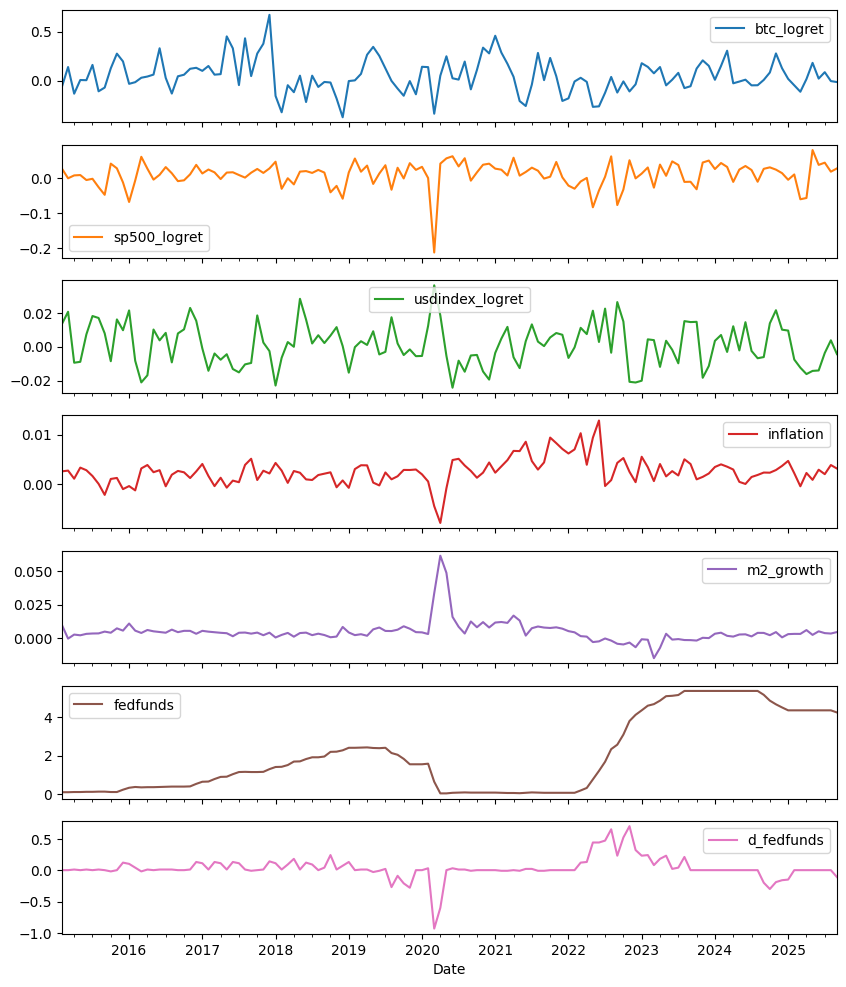

In [7]:
import matplotlib.pyplot as plt

market_data.plot(subplots=True, figsize=(10, 12))

plt.show()

In [8]:
# Separate DataFrame for Ethereum analysis
market_data_eth = pd.concat(
    [
        eth_logret,
        sp500_logret,
        usdindex_logret,
        inflation,
        m2_growth,
        fedfunds_m,
        d_fedfunds,
    ],
    axis=1,
).dropna()

market_data_eth.to_csv(OUT_DIR / "market_data_eth.csv", index=True)